In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

#import graphviz
#import tensorflow as tf



from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
DIR = Path('./preprocessed/')

train = pd.read_csv(DIR / 'train_preprocessed.csv')
validation = pd.read_csv(DIR / 'validation_preprocessed.csv')

train["date"] = pd.to_datetime(train.date)
validation["date"] = pd.to_datetime(validation.date)

train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")

validation.onpromotion = validation.onpromotion.astype("float16")
validation.sales = validation.sales.astype("float32")

In [3]:
# Define mean_squared_log_error
from sklearn.metrics import mean_squared_log_error

# Get the Root Mean Squared Logarithmic Error (RMSLE) for the random forest
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

In [4]:
train = train.drop(['onpromotion'], axis=1)
validation = validation.drop(['onpromotion'], axis=1)

In [5]:
validation.set_index('date', inplace=True)
train.set_index('date', inplace=True)

In [6]:
validation.head()

,sales
date,
2017-07-31,885856.8125
2017-08-01,988527.7500
2017-08-02,964712.0000
2017-08-03,728068.5000
2017-08-04,827775.6875


## EDA

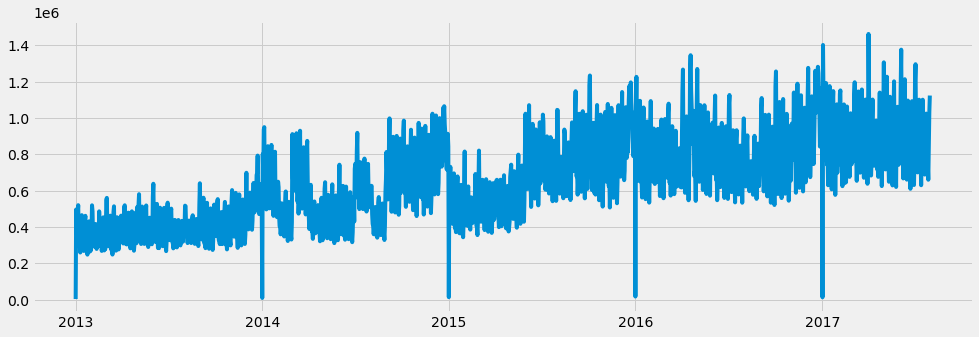

In [7]:
plt.figure(figsize=(15,5))
plt.plot(train.sales)

In [8]:
# what are possible candidates for further time-series plots?


## Split Data

## Feature Engineering

In [9]:
# Feature Engineering
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['y_difference'] = df.sales.diff()
    df['x_difference'] = df.y_difference.shift(1)
    df['y_sales'] = df.sales
    df['x_sales'] = df.sales.shift(1)

    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'x_difference']]
    y = df[['y_sales', 'y_difference', 'x_sales']]
    return X, y

In [10]:
X_train, y_train = create_features(train, label='sales')
X_test, y_test = create_features(validation, label='sales')

/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_23002/3154713137.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
/var/folders/j8/19vl2ybn33xf0x7k1_703k340000gp/T/ipykernel_23002/3154713137.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [11]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x_difference
date,,,,,,,,,
2013-01-01,0,1,1,1,2013,1,1,1,NaN
2013-01-02,0,2,1,1,2013,2,2,1,NaN
2013-01-03,0,3,1,1,2013,3,3,1,493580.78125
2013-01-04,0,4,1,1,2013,4,4,1,-134631.18750
2013-01-05,0,5,1,1,2013,5,5,1,-7001.53125
...,...,...,...,...,...,...,...,...,...
2017-07-26,0,2,3,7,2017,207,26,30,-102982.68750
2017-07-27,0,3,3,7,2017,208,27,30,27071.43750
2017-07-28,0,4,3,7,2017,209,28,30,-80803.25000


In [12]:
y_train

,y_sales,y_difference,x_sales
date,,,
2013-01-01,2.511619e+03,NaN,NaN
2013-01-02,4.960924e+05,493580.78125,2.511619e+03
2013-01-03,3.614612e+05,-134631.18750,4.960924e+05
2013-01-04,3.544597e+05,-7001.53125,3.614612e+05
2013-01-05,4.773501e+05,122890.43750,3.544597e+05
...,...,...,...
2017-07-26,7.406531e+05,27071.43750,7.135816e+05
2017-07-27,6.598498e+05,-80803.25000,7.406531e+05
2017-07-28,8.350997e+05,175249.87500,6.598498e+05


## Train Model

In [13]:
# in x_train and y_train remove Nans and replace with 0
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)
X_test = X_test.fillna(0)

In [14]:
reg = DecisionTreeRegressor(max_depth = 20)
reg.fit(X_train, y_train['y_difference'])



DecisionTreeRegressor(max_depth=20)

In [15]:
# plt.figure(figsize=(10,8), dpi=150)

# plot_tree(reg, feature_names=X_train.columns, filled=True, rounded=True) 
# plt.show()



## Predict

In [16]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

In [17]:
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,x_difference
date,,,,,,,,,
2017-07-31,0,0,3,7,2017,212,31,31,0.0000
2017-08-01,0,1,3,8,2017,213,1,31,0.0000
2017-08-02,0,2,3,8,2017,214,2,31,102670.9375
2017-08-03,0,3,3,8,2017,215,3,31,-23815.7500
2017-08-04,0,4,3,8,2017,216,4,31,-236643.5000
2017-08-05,0,5,3,8,2017,217,5,31,99707.1875
2017-08-06,0,6,3,8,2017,218,6,31,137917.9375
2017-08-07,0,0,3,8,2017,219,7,32,83865.5000
2017-08-08,0,1,3,8,2017,220,8,32,-252094.1875


In [18]:
validation['prediction_difference'] = reg.predict(X_test)
validation['prediction_sales'] =validation['prediction_difference'] + validation['x_sales']
data_all = pd.concat([train, validation], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_difference,x_difference,y_sales,x_sales,prediction_difference,prediction_sales
date,,,,,,,,,,,,,,,,
2013-01-01,2511.618896,2013-01-01,0,1,1,1,2013,1,1,1,NaN,NaN,2511.618896,NaN,NaN,NaN
2013-01-02,496092.406250,2013-01-02,0,2,1,1,2013,2,2,1,493580.78125,NaN,496092.406250,2511.618896,NaN,NaN
2013-01-03,361461.218750,2013-01-03,0,3,1,1,2013,3,3,1,-134631.18750,493580.78125,361461.218750,496092.406250,NaN,NaN
2013-01-04,354459.687500,2013-01-04,0,4,1,1,2013,4,4,1,-7001.53125,-134631.18750,354459.687500,361461.218750,NaN,NaN
2013-01-05,477350.125000,2013-01-05,0,5,1,1,2013,5,5,1,122890.43750,-7001.53125,477350.125000,354459.687500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.750000,2017-08-11,0,4,3,8,2017,223,11,32,174986.81250,-82752.75000,826373.750000,651386.937500,94130.2500,7.455172e+05
2017-08-12,792630.562500,2017-08-12,0,5,3,8,2017,224,12,32,-33743.18750,174986.81250,792630.562500,826373.750000,203587.5000,1.029961e+06
2017-08-13,865639.687500,2017-08-13,0,6,3,8,2017,225,13,32,73009.12500,-33743.18750,865639.687500,792630.562500,46920.1875,8.395508e+05


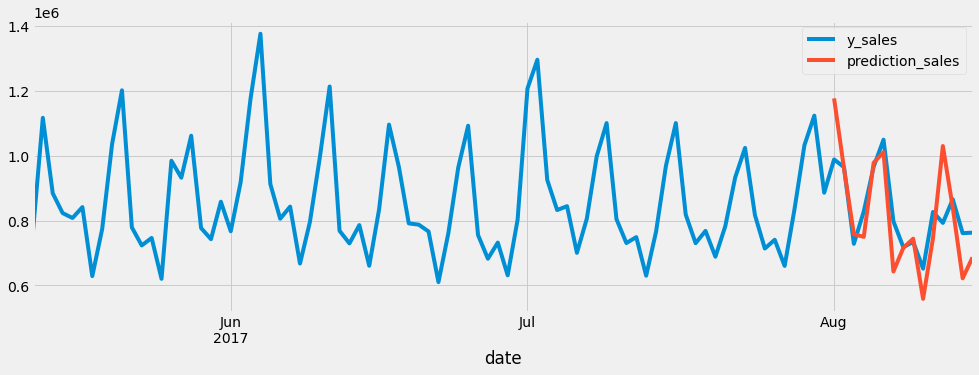

In [19]:
_ = data_all[['y_sales','prediction_sales']].tail(16*6).plot(figsize=(15, 5))


In [28]:
data_all['prediction_sales'].tail(15)

date
2017-08-01    1.177013e+06
2017-08-02    9.610108e+05
2017-08-03    7.578244e+05
2017-08-04    7.495516e+05
2017-08-05    9.782594e+05
2017-08-06    1.011112e+06
2017-08-07    6.427186e+05
2017-08-08    7.155332e+05
2017-08-09    7.438953e+05
2017-08-10    5.582597e+05
2017-08-11    7.455172e+05
2017-08-12    1.029961e+06
2017-08-13    8.395508e+05
2017-08-14    6.215895e+05
2017-08-15    6.863107e+05
Name: prediction_sales, dtype: float64

In [30]:
data_all['y_sales'].tail(15)

date
2017-08-01    9.885278e+05
2017-08-02    9.647120e+05
2017-08-03    7.280685e+05
2017-08-04    8.277757e+05
2017-08-05    9.656936e+05
2017-08-06    1.049559e+06
2017-08-07    7.974649e+05
2017-08-08    7.177664e+05
2017-08-09    7.341397e+05
2017-08-10    6.513869e+05
2017-08-11    8.263738e+05
2017-08-12    7.926306e+05
2017-08-13    8.656397e+05
2017-08-14    7.609224e+05
2017-08-15    7.626619e+05
Name: y_sales, dtype: float32

In [36]:
print('mean_squared_error ' + str(mean_squared_error(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))
print('mean_absolute_error ' + str(mean_absolute_error(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))
print('rmsle ' + str(rmsle(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))

mean_squared_error 11045849115.888842
mean_absolute_error 78066.8316951567
rmsle 0.12811156493723647


In [21]:
# Task: compare the result for decision trees, that differ in their complexity i.e. depth of the tree

## Random Forest

In [38]:
rf = RandomForestRegressor()

In [39]:
rf.fit(X_train, y_train['y_difference'])


RandomForestRegressor()

In [40]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)


In [59]:
validation['prediction_difference'] = rf.predict(X_test)
validation['prediction_sales'] =validation['prediction_difference'] + validation['x_sales']
data_all = pd.concat([train, validation], sort=False)
data_all

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 3

In [61]:
validation.tail(15)

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_difference,x_difference,y_sales,x_sales,prediction_difference,prediction_sales
date,,,,,,,,,,,,,,,,
2017-08-01,9.885278e+05,2017-08-01,0,1,3,8,2017,213,1,31,102670.9375,NaN,9.885278e+05,8.858568e+05,772481.443432,1.658338e+06
2017-08-02,9.647120e+05,2017-08-02,0,2,3,8,2017,214,2,31,-23815.7500,102670.9375,9.647120e+05,9.885278e+05,821369.126465,1.809897e+06
2017-08-03,7.280685e+05,2017-08-03,0,3,3,8,2017,215,3,31,-236643.5000,-23815.7500,7.280685e+05,9.647120e+05,733792.171394,1.698504e+06
2017-08-04,8.277757e+05,2017-08-04,0,4,3,8,2017,216,4,31,99707.1875,-236643.5000,8.277757e+05,7.280685e+05,776342.867373,1.504411e+06
2017-08-05,9.656936e+05,2017-08-05,0,5,3,8,2017,217,5,31,137917.9375,99707.1875,9.656936e+05,8.277757e+05,942739.079076,1.770515e+06
2017-08-06,1.049559e+06,2017-08-06,0,6,3,8,2017,218,6,31,83865.5000,137917.9375,1.049559e+06,9.656936e+05,940662.612906,1.906356e+06
2017-08-07,7.974649e+05,2017-08-07,0,0,3,8,2017,219,7,32,-252094.1875,83865.5000,7.974649e+05,1.049559e+06,781630.007972,1.831189e+06
2017-08-08,7.177664e+05,2017-08-08,0,1,3,8,2017,220,8,32,-79698.5625,-252094.1875,7.177664e+05,7.974649e+05,708569.954867,1.506035e+06
2017-08-09,7.341397e+05,2017-08-09,0,2,3,8,2017,221,9,32,16373.3125,-79698.5625,7.341397e+05,7.177664e+05,720721.810060,1.438488e+06


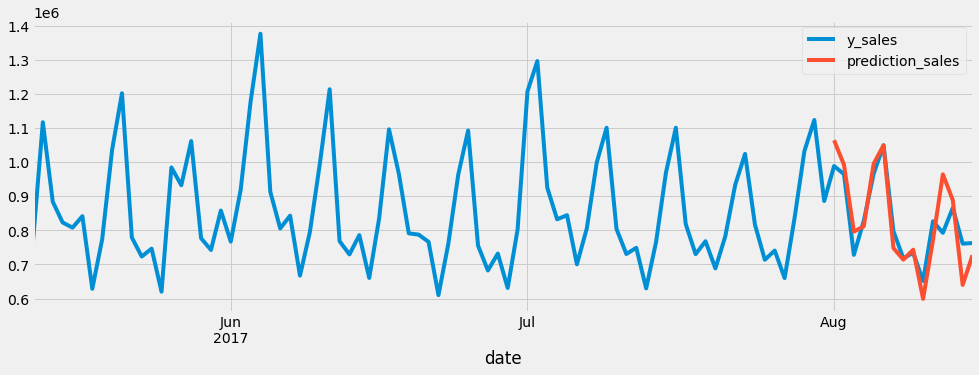

In [42]:
_ = data_all[['y_sales','prediction_sales']].tail(16*6).plot(figsize=(15, 5))


In [43]:
## Perform Hyeroarameter Tuning for the Random Forest. Use different approaches 
#(random search, grid search, Sequantial Model Based Optimization and a Genetic Algorithm)

In [44]:
# Random Search


In [81]:
# Perform a grid search for the best parameters for the random forest
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
                            
grid_search.fit(X_train, y_train['y_difference'])

grid_search.best_params_

# Use this grid_search.best_params_ to create a new random forest with the best parameters
rf = RandomForestRegressor(bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000)



Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.7s
[CV] E

In [90]:
rf.fit(X_train, y_train['y_difference'])

RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=1000)

In [91]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

In [92]:
validation['prediction_difference'] = rf.predict(X_test)
validation['prediction_sales'] =validation['prediction_difference'] + validation['x_sales']
data_all = pd.concat([train, validation], sort=False)
data_all

,sales,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y_difference,x_difference,y_sales,x_sales,prediction_difference,prediction_sales
date,,,,,,,,,,,,,,,,
2013-01-01,2511.618896,2013-01-01,0,1,1,1,2013,1,1,1,NaN,NaN,2511.618896,NaN,NaN,NaN
2013-01-02,496092.406250,2013-01-02,0,2,1,1,2013,2,2,1,493580.78125,NaN,496092.406250,2511.618896,NaN,NaN
2013-01-03,361461.218750,2013-01-03,0,3,1,1,2013,3,3,1,-134631.18750,493580.78125,361461.218750,496092.406250,NaN,NaN
2013-01-04,354459.687500,2013-01-04,0,4,1,1,2013,4,4,1,-7001.53125,-134631.18750,354459.687500,361461.218750,NaN,NaN
2013-01-05,477350.125000,2013-01-05,0,5,1,1,2013,5,5,1,122890.43750,-7001.53125,477350.125000,354459.687500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.750000,2017-08-11,0,4,3,8,2017,223,11,32,174986.81250,-82752.75000,826373.750000,651386.937500,109535.220852,760922.158352
2017-08-12,792630.562500,2017-08-12,0,5,3,8,2017,224,12,32,-33743.18750,174986.81250,792630.562500,826373.750000,132069.963340,958443.713340
2017-08-13,865639.687500,2017-08-13,0,6,3,8,2017,225,13,32,73009.12500,-33743.18750,865639.687500,792630.562500,73788.760974,866419.323474


In [93]:
reg.predict(X_test).shape

(16,)

In [94]:
rf.predict(X_test).shape

(16,)

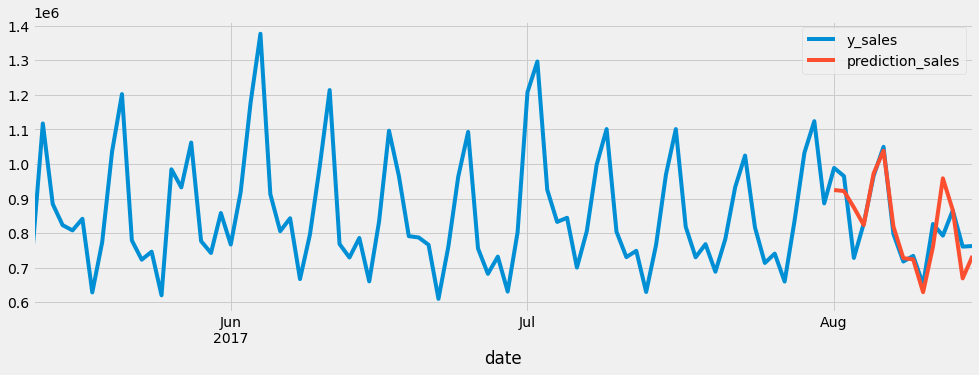

In [95]:
_ = data_all[['y_sales','prediction_sales']].tail(16*6).plot(figsize=(15, 5))


In [96]:
print('mean_squared_error ' + str(mean_squared_error(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))
print('mean_absolute_error ' + str(mean_absolute_error(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))
print('rmsle ' + str(rmsle(data_all['y_sales'].tail(15), data_all['prediction_sales'].tail(15))))

mean_squared_error 4648461025.243777
mean_absolute_error 46158.14998181017
rmsle 0.0830587590563084
